In [1]:
# !pwd

# import torch
# print(torch.cuda.is_available())

# ! git clone https://github.com/hemantkashniyal/EVA4.git || true
# ! git -C EVA4 pull
# ! cp -r /content/EVA4/notebooks/Session8/* .

In [2]:
%env PYTHONDONTWRITEBYTECODE=true
! pip install -r requirements.txt
    

env: PYTHONDONTWRITEBYTECODE=true


In [3]:
%matplotlib inline

import json
from torchsummary import summary
from environs import Env

from torchvision import datasets, transforms
from eva4.common import reset_seed, get_config, get_device
env = Env()
env.read_env("./cifar10.experiment.env", recurse=False)

reset_seed()
model_config = get_config(env)
print("Experiment Config: ", json.dumps(model_config, sort_keys=False, indent=4))

Experiment Config:  {
    "cuda_available": false,
    "device": "cpu",
    "epochs": 100,
    "desired_accuracy": 80.0,
    "break_on_reaching_desired_accuracy": true,
    "consecutive_desired_accuracy": 3,
    "input_size": [
        3,
        32,
        32
    ],
    "input_channel": 3,
    "input_dimension": [
        32,
        32
    ],
    "dataset": "CIFAR10",
    "batch_size": 64,
    "shuffle": true,
    "num_workers": 1,
    "pin_memory": true,
    "dropout": 0.1,
    "bias_enabled": true,
    "optimizer": "SGD",
    "learning_rate": 0.1,
    "momentum": 0.9,
    "scheduler": "MultiStepLR",
    "step_size": 3,
    "milestones": [
        10,
        20,
        35,
        50
    ],
    "gamma": 0.1
}


In [4]:
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop
from eva4.dataloader.cifar10 import get_mean_std, get_data_loader, DATA_CLASSES, print_data_stats

train_transforms = None
test_transforms = None

reset_seed()
train_loader, test_loader = get_data_loader(train_transforms, test_transforms, model_config)

train_data_mean, train_data_std = get_mean_std()
test_data_mean, test_data_std = get_mean_std()


Files already downloaded and verified
Files already downloaded and verified
CIFAR10 data_mean: (0.4914, 0.4822, 0.4465)
CIFAR10 data_std: (0.247, 0.2435, 0.2616)
CIFAR10 data_mean: (0.4914, 0.4822, 0.4465)
CIFAR10 data_std: (0.247, 0.2435, 0.2616)


In [5]:
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop

input_size = model_config.get("input_size")
crop_size = model_config.get("input_dimension")
angle_std = 7 # in degrees


# Define training transforms
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize(crop_size),
                                      RandomRotatedCrop(crop_size, 0.0, angle_std, downscale=0.5),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_data_mean, train_data_std)
                                      ])

# Define test transforms
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize(crop_size),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_data_mean, train_data_std)
                                      ])

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

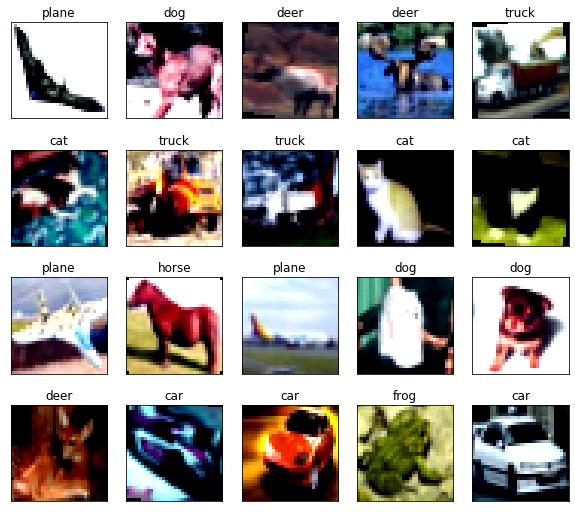

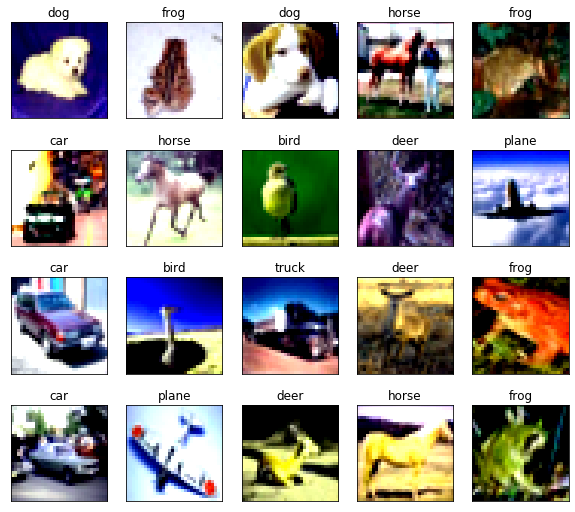

In [6]:
reset_seed()
train_loader, test_loader = get_data_loader(train_transforms, test_transforms, model_config)

# preview a few of the images from training and test
print_data_stats(train_loader, model_config)
print_data_stats(test_loader, model_config)

In [ ]:
from eva4.network.resnet import ResNet18
from eva4.optimizer import get_optimizer
from eva4.scheduler import get_scheduler
from eva4.train import start_training

reset_seed()
train_loader, test_loader = get_data_loader(train_transforms, test_transforms, model_config)

# create device/model/optimizer/scheduler based on the experiment config
device = get_device(model_config)

# model contains following convolution blocks 
## input block -> contains dilated convolution and depth separable convolution
## transition block
## internal block 1 -> contains depth separable convolution
## transition block
## internal block 2
## transition block
## output block
model = ResNet18().to(device)
optimizer = get_optimizer(model, model_config)
scheduler = get_scheduler(optimizer, model_config)

input_size = (3,32,32)
summary(model, input_size = input_size)
start_training(model, device, train_loader, test_loader, optimizer, scheduler, model_config)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/782 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Loss=-66.24872589111328 Batch_id=5 Accuracy=12.50:   1%|          | 6/782 [00:14<32:00,  2.47s/it] 